@todo: batch effects from the 

# 0. Load data
as much of the microenvironment features as possible while tolerating 0 NaNs

In [13]:
%load_ext autoreload
%autoreload 2

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    
import umap

# Suppress batch effects
def scale_by_region(df):
    scaled = []
    for region,_df in df.groupby('Region'):
        _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
        _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
                           data=_X)
        _df['Region'] = region
        scaled.append(_df)
    return pd.concat(scaled)
    

In [2]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = all_df[all_df['Cell type','Meta'] == 'Basal']
basals = basals[~basals['Border','Meta'].astype(bool)]

cols2drop = [(f,'Measurement') for f in basals.droplevel(axis=1,level=1) if 'Age' in f]
cols2drop += [(f,'Measurement') for f in basals.droplevel(axis=1,level=1) if 'Time' in f]
basals = basals.drop(columns=cols2drop)
basals.shape


(8215, 1404)

### Separate measurement fields into constituent types
1. 'geom': Cell geometry
2. 'temporal': Cell rates and lookbacks
3. 'adjac': microenvironment/relative

In [6]:
# Filter only for geom features

meas_names = basals.xs('Measurement',level=1,axis=1).columns
meas_types = pd.DataFrame(index=meas_names)
meas_types['Type'] = 'geom'
meas_types.loc[ meas_names.str.contains('rate'),'Type' ] = 'temporal'
meas_types.loc[ meas_names.str.contains('adjac'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('duration'),'Type' ] = 'duration'
meas_types.loc[ meas_names.str.contains('neighbors'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('Relative'),'Type' ] = 'relative'
meas_types.loc[ meas_names.str.contains('prior'),'Type' ] = 'temporal'

cols2keep = [(f,'Measurement') for f in meas_types[meas_types['Type'] == 'geom'].index]
cols2keep += [(f,'Measurement') for f in meas_types[meas_types['Type'] == 'temporal'].index]
cols2keep += [(f,'Measurement') for f in meas_types[meas_types['Type'] == 'adjac'].index]
metacols = [(f,'Meta') for f in basals.xs('Meta',level=1,axis=1)]

all_meas = basals[cols2keep]
all_meas = all_meas.dropna(subset=cols2keep,axis=0)
all_meas['Region'] = basals['Region']
all_meas

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_62920/3036034970.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_meas['Region'] = basals['Region']


Name          Nuclear volume Nuclear solidity           Z           Y  \
Metadata         Measurement      Measurement Measurement Measurement   
Frame TrackID                                                           
1     R1_11         114.9375         0.852573   44.208809  102.628603   
      R1_31         176.4375         0.846223   47.328374   25.138062   
      R1_60         131.7500         0.803966   46.293169  100.852467   
      R1_64         169.0000         0.926027   47.824704   25.978458   
      R1_71         125.2500         0.805143   51.640220   52.802146   
...                      ...              ...         ...         ...   
14    R2_880        253.0625         0.919809   55.200049   77.580082   
      R2_881        279.0000         0.909906   55.582661   85.625112   
      R2_1057       137.0000         0.872611   43.682026   96.133326   
      R2_1058       136.8750         0.899384   47.228767   93.814155   
      R2_1087       125.6875         0.787392   52.773247   83.006340   

Name                    X Nuclear height Cell volume      Z-cyto      Y-cyto  \
Metadata      Measurement    Measurement Measurement Measurement Measurement   
Frame TrackID                                                                  
1     R1_11     35.245242          -12.0    376.8125   44.568917  102.653964   
      R1_31     35.516383          -11.0    381.6875   47.072376   25.119985   
      R1_60     39.210033          -11.0    430.5625   45.865438  101.234359   
      R1_64    108.396542          -11.0    505.0000   47.346163   26.238274   
      R1_71     11.936876          -11.0    372.2500   51.399597   52.925034   
...                   ...            ...         ...         ...         ...   
14    R2_880   101.209558          -11.0    703.0000   54.491198   78.134891   
      R2_881   102.665099          -13.0    708.3125   55.468367   85.797715   
      R2_1057   38.064667           -9.0    440.4375   43.366113   96.260004   
      R2_1058   33.073858           -9.0    499.8750   47.229057   94.376532   
      R2_1087   19.491546          -12.0    450.0000   51.852500   82.801632   

Name               X-cyto  ... Std adjac Distance to closest macrophage  \
Metadata      Measurement  ...                              Measurement   
Frame TrackID              ...                                            
1     R1_11     35.176771  ...                                 4.526654   
      R1_31     35.491813  ...                                 1.658751   
      R1_60     39.286507  ...                                 3.492019   
      R1_64    108.671225  ...                                 2.810705   
      R1_71     12.042772  ...                                 1.473597   
...                   ...  ...                                      ...   
14    R2_880   101.039963  ...                                 2.352355   
      R2_881   102.931086  ...                                 1.968221   
      R2_1057   37.970448  ...                                 2.115730   
      R2_1058   33.252907  ...                                 4.179398   
      R2_1087   19.208264  ...                                 2.110473   

Name          Std adjac Nuclear volume standard  \
Metadata                            Measurement   
Frame TrackID                                     
1     R1_11                            0.088407   
      R1_31                            0.230371   
      R1_60                            0.104616   
      R1_64                            0.301884   
      R1_71                            0.136630   
...                                         ...   
14    R2_880                           0.321291   
      R2_881                           0.333564   
      R2_1057                          0.153841   
      R2_1058                          0.258032   
      R2_1087                          0.152408   

Name          Std adjac Cell volume standard  \
Metadata                         Measureme

In [5]:
# Standardize

meas_scaled_by_region = scale_by_region(all_meas)
scaled_data = meas_scaled_by_region.drop(columns='Region')

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_62920/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_62920/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_62920/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_62920/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact 

## 1. Examine batch effect
- entropy difference of mean
- order by effect size

In [7]:
df = meas_scaled_by_region.droplevel(axis=1,level=1)
regions = {name:_df for name,_df in df.groupby('Region')}
r1 = regions['R1']
r2 = regions['R2']

feature_names = df.columns.drop('Region')

In [8]:
diffs_of_means = np.array([ np.abs(np.diff(df.groupby('Region')[f].mean())) for f in feature_names])
diffs_of_means = pd.DataFrame(diffs_of_means, index=feature_names, columns = ['Diff of means']).sort_values(by='Diff of means')

diffs_of_stds = np.array([ np.abs(np.diff(df.groupby('Region')[f].std())) for f in feature_names])
diffs_of_stds = pd.DataFrame(diffs_of_stds, index=feature_names, columns = ['Diff of means']).sort_values(by='Diff of means')

In [9]:
diffs_of_means.tail(10)

,Diff of means
Name,
Min adjac NC ratio,2.432197e-15
Max adjac Basal eccentricity,2.436378e-15
Median adjac nuc_shcoeffs_surface_area,2.458892e-15
Max adjac Nuclear solidity,2.817633e-15
Median adjac Mean H2B intensity at 1 frame prior,3.009621e-15
Nuclear solidity,3.363134e-15
Min adjac cyto_shcoeffs_L0M0C at 1 frame prior,3.408094e-15
Median adjac cyto_shcoeffs_L0M0C at 1 frame prior,3.751375e-15
Mean adjac cyto_shcoeffs_L0M0C,6.252574e-15


In [10]:
diffs_of_stds.tail(10)

,Diff of means
Name,
Std adjac nuc_shcoeffs_L1M1S,0.000142
Std adjac nuc_shcoeffs_L5M5C at 1 frame prior,0.000142
Median adjac nuc_shcoeffs_L5M5S at 1 frame prior,0.000142
cyto_shcoeffs_L4M1S,0.000142
Mean adjac Basal eccentricity,0.000142
Median adjac Mean curvature - cell coords,0.000142
cyto_shcoeffs_L5M1C,0.000142
Mean adjac cyto_shcoeffs_L5M2C at 1 frame prior,0.000142
Min adjac cyto_shcoeffs_L2M1S at 1 frame prior,0.000142


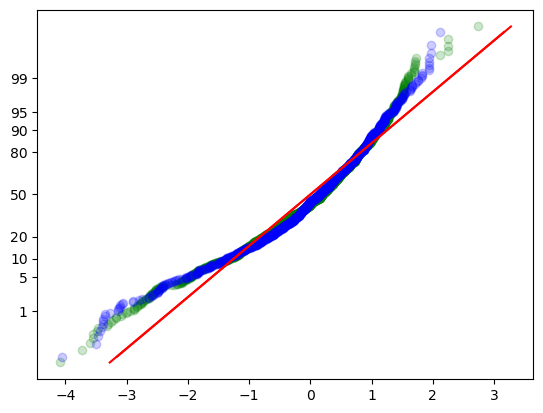

In [27]:
from mathUtils import normplot

# plt.subplot(2,1,1)
normplot(r1['Max adjac Nuclear solidity at 1 frame prior'],color='g')
# plt.subplot(2,1,2)
normplot(r2['Max adjac Nuclear solidity at 1 frame prior'],color='b')

### KS distance between R1/R2 for each feature

In [46]:
from scipy.stats import ks_2samp

ks_of_feature = {f: -np.log10(ks_2samp(regions['R1'][f], regions['R2'][f]).pvalue) for f in feature_names}
ks_of_feature = pd.Series(ks_of_feature).sort_values()

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_62920/1636031616.py:3: RuntimeWarning: divide by zero encountered in log10
  ks_of_feature = {f: -np.log10(ks_2samp(regions['R1'][f], regions['R2'][f]).pvalue) for f in feature_names}


In [62]:
print(ks_of_feature.head(10))
ks_of_feature.tail(40)

Mean adjac cyto_shcoeffs_L5M2C                       0.000142
Mean adjac nuc_shcoeffs_L5M1C                        0.000173
Mean adjac nuc_shcoeffs_L3M1S at 1 frame prior       0.000406
Mean adjac cyto_shcoeffs_surface_area                0.000683
Std adjac cyto_shcoeffs_L4M2C                        0.001240
Mean adjac cyto_shcoeffs_L4M4S at 1 frame prior      0.001317
Median adjac cyto_shcoeffs_L4M4S at 1 frame prior    0.001339
Std adjac cyto_shcoeffs_L5M1C                        0.001348
Std adjac cyto_shcoeffs_L4M3S at 1 frame prior       0.001440
Mean adjac cyto_shcoeffs_L5M2C at 1 frame prior      0.001843
dtype: float64


Median adjac Cell height at 1 frame prior                                      8.644971
Min adjac Nuclear volume G1 only exponential growth rate at 1 frame prior      8.944273
Min adjac Nuclear solidity                                                    12.599232
Min adjac Cell height at 1 frame prior                                        14.132359
Min adjac Nuclear solidity at 1 frame prior                                   15.096626
Min adjac Cell height                                                         15.624853
Max adjac Basal alignment                                                     19.157304
Max adjac NC ratio at 1 frame prior                                           20.425833
Std adjac Nuclear solidity                                                    20.848585
Max adjac Cell height at 1 frame prior                                        21.616902
Max adjac Cell height                                                         22.088778
Std adjac Nuclear solidity at 1 

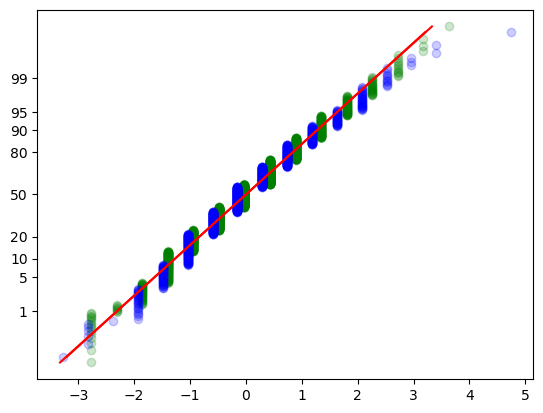

In [64]:
f= 'Min adjac Cell height'
from mathUtils import normplot

normplot(r1[f],color='g')
normplot(r2[f],color='b')

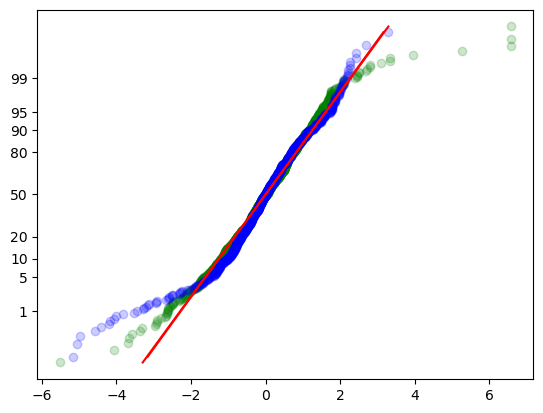

In [61]:
f= 'Max adjac Mean curvature at 1 frame prior'
from mathUtils import normplot

normplot(r1[f],color='g')
normplot(r2[f],color='b')
